In [15]:
#!pip install numpy 
#!pip install nbformat 
#!pip install matplotlib

import time
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go #for 3D plot
import concurrent.futures
import multiprocessing
import os

In [16]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def gene_generator(min_range, max_range, m, n):
    num_of_genes = 2**n - 1
    interval = (max_range - min_range) / num_of_genes
    gene_value = []
    for i in range(num_of_genes+1):
        gene_value.append(min_range+i*interval)
    gene = [[*bin(i)[2:].zfill(4)] for i in range(0, num_of_genes+1)]
    return gene_value, gene

def griewank(x, start_time):
    x = x - (time.time()-start_time)/2
    sum_term = np.sum(x**2 / 4000)
    prod_term = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return float(1 + sum_term - prod_term)

def rosenbrock(x, a=1, b=100):
    sum_term = np.sum((a - x[:-1])**2)
    prod_term = np.sum(b * (x[1:] - x[:-1]**2)**2)
    return (sum_term + prod_term)

def sphere(x):
    return np.sum(x**2)

def ackley(x, start_time):
    x = x - 10*(time.time()-start_time)
    a=20 
    b=0.2 
    c=2*np.pi, 
    n = len(x)
    sum1 = np.sum(x**2)
    sum2 = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
    term2 = -np.exp(sum2 / n)
    return term1 + term2 + a + np.exp(1)

def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def zakharov(x):
    sum1 = np.sum(x**2)
    sum2 = np.sum(0.5 * np.arange(1, len(x) + 1) * x)
    return sum1 + sum2**2 + sum2**4

def population_value_generator(obj_fun, population, gene_value, start_time):
    population_values = []
    obj_func_values = []
    # Evaluate each chromosome in the population
    for chromosome in population:
        chromosome_values = []
        for gene in chromosome:
            bin_str = ''.join(map(str, gene))
            dec_num = int(bin_str, 2)
            chromosome_values.append(gene_value[dec_num])
        if obj_fun == "Griewank":
            obj_func_value = griewank(np.array(chromosome_values), start_time)
        elif obj_fun == "Rosenbrock":
            obj_func_value = rosenbrock(np.array(chromosome_values))
        elif obj_fun == "Ackley":
            obj_func_value = ackley(np.array(chromosome_values),start_time)
        elif obj_fun == "Sphere":
            obj_func_value = sphere(np.array(chromosome_values))
        elif obj_fun == "Rastrigin":
            obj_func_value = rastrigin(np.array(chromosome_values))
        elif obj_fun == "Zakharov":
            obj_func_value = zakharov(np.array(chromosome_values))
        else:
            print("Give Correct Objective Function") 
        obj_func_values.append(obj_func_value)
        population_values.append(chromosome_values)
    return population_values, obj_func_values

def thresholding(optm, obj_func_values, threshold):
    if optm == "min":
        selected_population_ind = np.argsort(obj_func_values)[:threshold]
    elif optm == "max":
        selected_population_ind = np.argsort(obj_func_values)[::-1][:threshold] #[:threshold]
    else:
        print("Define optimisation as maximise or minimise")
    return selected_population_ind

def fitness_estimation(selected_population, obj_func_values):
    fitness_values = []
    for ind in selected_population:
        fitness = 1/(1 + obj_func_values[ind])
        fitness_values.append(fitness)
    return(fitness_values)

def Roulette_wheel(selected_population_ind, fitness_values, threshold, no_of_child):
    parents = set()
    while len(parents) < no_of_child:
        fitness_probability = []
        for fit_value in fitness_values:
            probability = fit_value/sum(fitness_values)
            fitness_probability.append(probability)
        parent = np.random.choice(selected_population_ind, p=fitness_probability, size=(2), replace=False).tolist()
        parents.add(tuple(parent))
    return tuple(parents)

def crossover(parents, population, m):
    children = []
    for parent in parents:
        cross_pt = np.random.randint(1, m)
        child = np.concatenate((population[parent[0]][:cross_pt], population[parent[1]][cross_pt:]))
        children.append(child)
    return children

def mutation(children,m,n):
    mutated_children = []
    for child in children:
        m_mutate = np.random.randint(0, m)
        n_mutate = np.random.randint(0, n)
        if child[m_mutate][n_mutate] == 0:
            child[m_mutate][n_mutate] = 1
        else:
            child[m_mutate][n_mutate] = 0
        mutated_children.append(child)
    return mutated_children

In [17]:
def genetic_algrithm(param):
    
    file_name, seed, p, m, n = param[:5]
    threshold, no_of_child, min_range = param[5:8]
    max_range, obj_fun, mutation_using_hamming_distance = param[8:11]
    num_of_mutation, optm, iter, start_time, previous_population = param[11:]

    np.random.seed(seed)

    f = []
    g = []
    f_lists = [[] for _ in range(p)]  # Create a list of empty lists

    gene_value, gene = gene_generator(min_range, max_range, m, n)
    #population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    population  = previous_population

    for i in range(iter):

        population_values, obj_func_values = population_value_generator(obj_fun, population, gene_value, start_time)
            
        #Monitoring Variables
        for j, value in enumerate(obj_func_values):
            f_lists[j].append(value)
        if optm == "min":
            f.append(min(obj_func_values))
            g.append(population_values[obj_func_values.index(max(obj_func_values))])
        elif optm == "max":
            f.append(max(obj_func_values))
            g.append(population_values[obj_func_values.index(max(obj_func_values))])
        else:
            print("Define optimisation as maximise or minimise")

        #Thresholding
        selected_population_ind = thresholding(optm, obj_func_values, threshold)
        selected_population = []
        for i in selected_population_ind:
            selected_population.append(population[i])

        #Fitness Estimation
        fitness_values = fitness_estimation(selected_population_ind, obj_func_values)

        #Roulette_wheel
        parents = Roulette_wheel(selected_population_ind, fitness_values, threshold, no_of_child)

        # Crossover
        children = crossover(parents, population, m)
           
        if mutation_using_hamming_distance == 'False':
            if num_of_mutation == 0:
                new_children = children
            else:
                for i in range(num_of_mutation):
                    new_children = mutation(children, m, n) #Issue with mutation. Mutate at many places
            
        # New Population
        population = selected_population + new_children
        
    value = f[len(f)-1]
    location = g[len(g)-1]
    index = f.index(value) + 1
    score = 100/(1+(index*value))
    result = {"value": value, "iteration": index, "location": location}
    fs = {"f": f, "f_lists": f_lists}
    
    return result, fs, population


In [18]:
#Intialisation
start_time = time.time()

scores = []
values = []
iterations    = []
true_values = []
station_values = []
num_workers = multiprocessing.cpu_count()

p = 6  # Population size / Number of chromosomes
m = 3 # Number of variables / genes
n = 4  # Number of digits / Alleles

threshold = 3 # Crossover threshold
no_of_child = 3
min_range = -600
max_range = 600 # Search Range

obj_fun = "Ackley" #"Griewank"/"Rosenbrock"
mutation_using_hamming_distance = 'False'
num_of_mutation = 1
optm = "min" #"max"
iter = 1000

times = 1
dir = 'Population_Variation'
file = 'genetic_algorithm_output_steps.txt'    
seeds = [42, 123, 314, 2020, 2024, 314, 2718, 101, 999, 2023, 555, 777, 1001, 333,
         888, 100, 200, 300, 400, 500, 600, 700, 1234, 5678, 9012, 3456, 7890]

for it in range(1,50):
    total_score, total_value, total_iteration = 0, 0, 0
    val = 2
    p = 2+(2*val)
    threshold = 1+val
    no_of_child = 1+val   
    
    #print("\np:",p,'\t', "m:",m,'\t',"n:",n)
    
    if it == 1:
        previous_population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    else:
        previous_population = pre_population

    params = [(file, seeds[k], p, m, n, threshold, no_of_child, min_range, max_range, obj_fun, 
    mutation_using_hamming_distance, num_of_mutation, optm, iter, start_time, previous_population) for k in range(times)]
        
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(genetic_algrithm, params))
    
    x = np.array([0, 0, 0])
    station_result = ackley(x, start_time)
    station_values.append(station_result)
    
    
    for output in results:
        result,fs, pre_population = output
        total_value += result['value']
        #total_iteration += result['iteration']
        location = result['location']
    avg_value, avg_iteration = total_value/times, total_iteration/times
    error = euclidean_distance(location, shifted_x)
    values.append(avg_value)
    iterations.append(avg_iteration) 
    scores.append(error)
    
    shifted_x = np.array([0, 0, 0]) + 10*(time.time() - start_time)
    true_result = ackley(shifted_x, start_time)
    print(f"\nTime: {time.time() - start_time:.2f}s, \nShifted New Position: {shifted_x}, \nBest posible (Minima search) result: {true_result}")
    print("Euclidean Distance:", error)
    true_values.append(true_result)
    
print("\nValue:", values)
#print("\niterations:", iterations)
print("\Errors:", scores)


Time: 0.93s, 
Shifted New Position: [9.28010941 9.28010941 9.28010941], 
Best posible (Minima search) result: 0.0002386077850222712
Euclidean Distance: 490.0228678249602

Time: 1.59s, 
Shifted New Position: [15.94030619 15.94030619 15.94030619], 
Best posible (Minima search) result: 0.0002768201472389542
Euclidean Distance: 765.3050797001674

Time: 2.28s, 
Shifted New Position: [22.83940315 22.83940315 22.83940315], 
Best posible (Minima search) result: 0.0002672661484948158
Euclidean Distance: 655.0893026737581

Time: 2.95s, 
Shifted New Position: [29.50995445 29.50995445 29.50995445], 
Best posible (Minima search) result: 0.0002290562081097569
Euclidean Distance: 770.2842090792757

Time: 3.61s, 
Shifted New Position: [36.10928297 36.10928297 36.10928297], 
Best posible (Minima search) result: 0.0002577127552112479
Euclidean Distance: 250.92896411047872

Time: 4.27s, 
Shifted New Position: [42.67124176 42.67124176 42.67124176], 
Best posible (Minima search) result: 0.0002290562081097

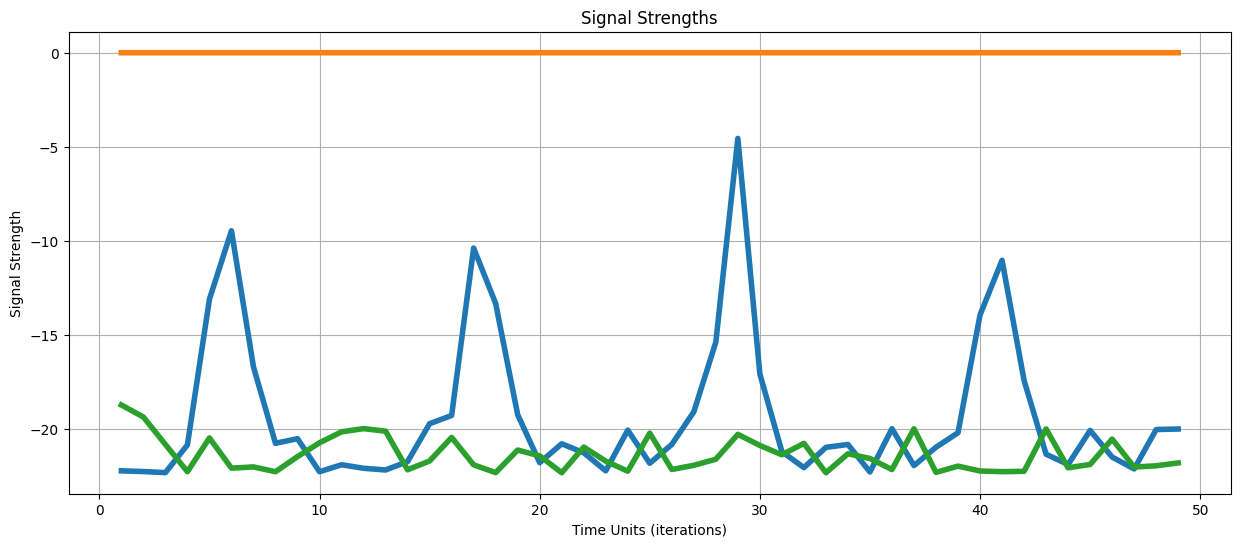

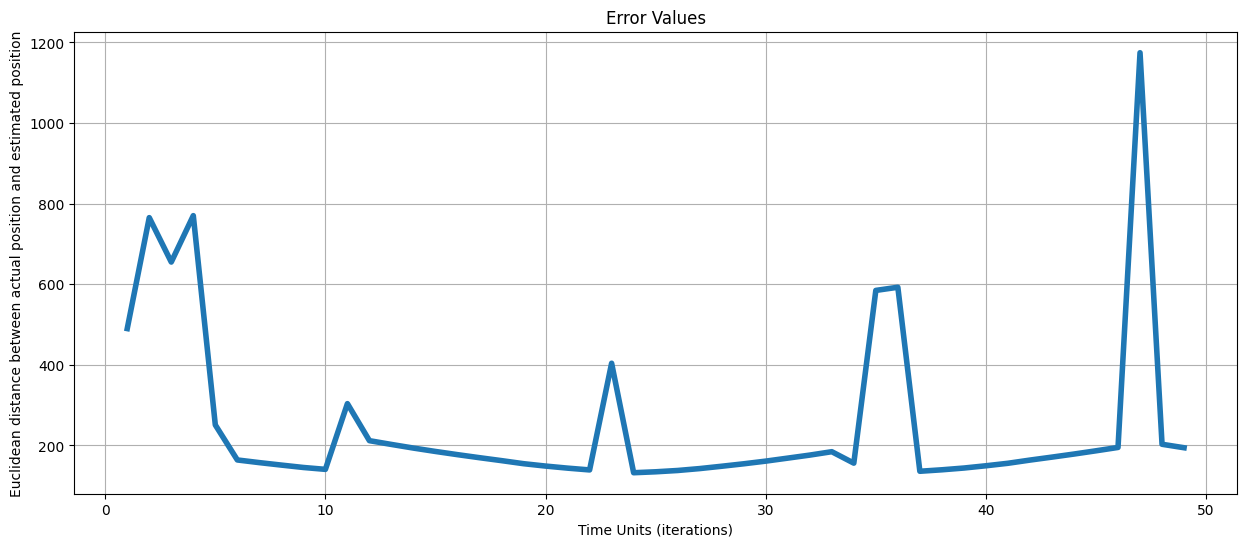

In [36]:
# Create a line plot
x = [i for i in range(1,50)]
signal_strength = [-1 * j for j in values]
max_signal_strength = [-1 * k for k in true_values]
static_signal_strength = [-1 * l for l in station_values]

plt.figure(figsize=(15, 6))
plt.plot(x, signal_strength, linewidth = '4', label="Signal Strength by using GA")
plt.plot(x, max_signal_strength, label="Maximum Signal Strength of the moving object",linewidth = '4')
plt.plot(x, static_signal_strength, label='Signal Strength without using any dynamic algorithm', linewidth = '4')
plt.title('Signal Strengths')
plt.xlabel('Time Units (iterations)')
plt.ylabel('Signal Strength')
plt.grid(True)
plt.show()

# Create a line plot
plt.figure(figsize=(15, 6))
plt.plot(x, scores, linewidth = '4')
plt.title('Error Values')
plt.xlabel('Time Units (iterations)')
plt.ylabel('Euclidean distance between actual position and estimated position')
plt.grid(True)
plt.show()

values_normal = values
iterations_normal = iterations
scores_normal = scores

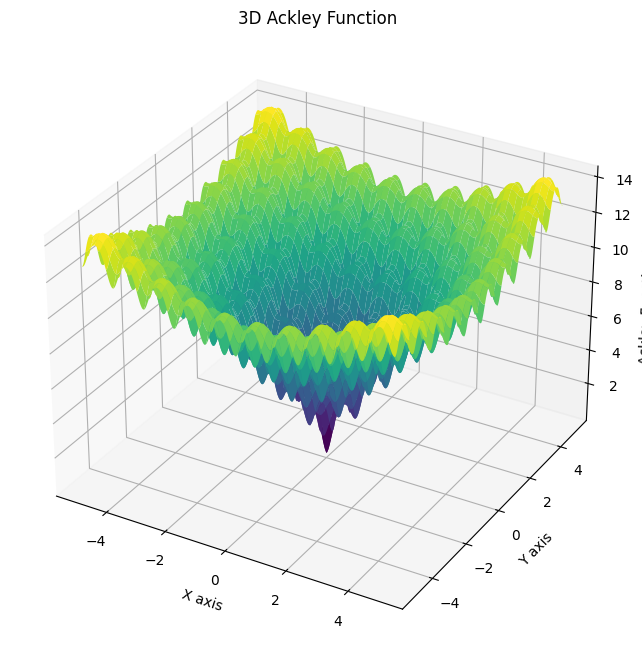

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Ackley function
def ackley(x, y):
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20

# Create a grid of points
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)

# Calculate the Ackley function values
Z = ackley(X, Y)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Labels and title
ax.set_title('3D Ackley Function')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Ackley Function Value')

plt.show()
